Random Forest Accuracy: 0.9881 
───────────────────────────────

Classification Report:
              precision    recall  f1-score   support

          P1       0.94      0.89      0.91      1116
          P2       0.99      1.00      1.00     16765
          P3       0.98      0.93      0.96      1454
          P4       1.00      0.98      0.99      1200

    accuracy                           0.99     20535
   macro avg       0.98      0.95      0.96     20535
weighted avg       0.99      0.99      0.99     20535



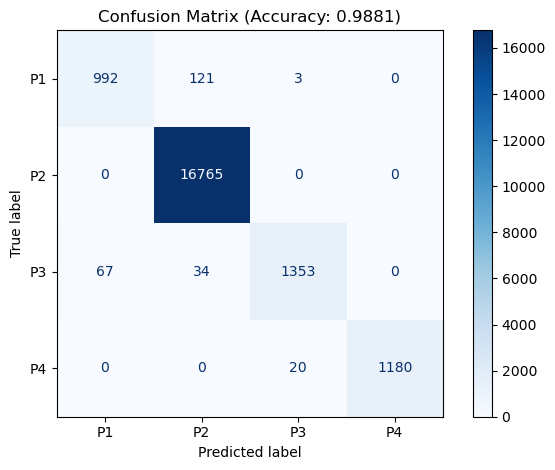

,Approved_Flag,Predicted,Actual_RiskLevel,Predicted_RiskLevel,Correct
0,P2,P2,Medium Risk - Review Needed,Medium Risk - Review Needed,True
1,P2,P2,Medium Risk - Review Needed,Medium Risk - Review Needed,True
2,P2,P2,Medium Risk - Review Needed,Medium Risk - Review Needed,True
3,P2,P2,Medium Risk - Review Needed,Medium Risk - Review Needed,True
4,P2,P2,Medium Risk - Review Needed,Medium Risk - Review Needed,True
5,P2,P2,Medium Risk - Review Needed,Medium Risk - Review Needed,True
6,P2,P2,Medium Risk - Review Needed,Medium Risk - Review Needed,True
7,P2,P2,Medium Risk - Review Needed,Medium Risk - Review Needed,True
8,P2,P2,Medium Risk - Review Needed,Medium Risk - Review Needed,True
9,P3,P3,High Risk - Likely Denied,High Risk - Likely Denied,True



Predictions saved to 'Artifacts/Predictions/prediction_results_random_forest.csv'


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from IPython.display import display, HTML

# Load train and test data
train_data = pd.read_csv("../Data/train_data.csv")
test_data = pd.read_csv("../Data/test_data.csv")

# Set target column
target_column = "Approved_Flag"

# Define leakage and identifier columns to drop
leakage_columns = [
    target_column,
    "CreditRisk",
    "LoanStatus",
    "IsDefault",
    "RiskLevel",
    "CustomerID",
    "ID",
    "ApplicationID"
]
drop_cols = [col for col in leakage_columns if col in train_data.columns]

# Separate features and encode categoricals
X_train_raw = train_data.drop(columns=drop_cols)
X_test_raw = test_data.drop(columns=drop_cols)

# Combine train and test for consistent encoding
combined = pd.concat([X_train_raw, X_test_raw], axis=0)
combined_encoded = pd.get_dummies(combined, drop_first=True)

# Split encoded back to train/test
X_train = combined_encoded.iloc[:len(X_train_raw), :]
X_test = combined_encoded.iloc[len(X_train_raw):, :]

# Encode target column to numeric
le = LabelEncoder()
y_train = le.fit_transform(train_data[target_column])
y_test = le.transform(test_data[target_column])

# Train Random Forest model
model = RandomForestClassifier(n_estimators=300, max_depth=10, random_state=52)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
y_pred_labels = le.inverse_transform(y_pred)

# Use string labels in comparison table
comparison_df = test_data.copy()
comparison_df["Predicted"] = y_pred_labels
comparison_df["Correct"] = comparison_df[target_column] == comparison_df["Predicted"]

# Evaluation
label_names = le.classes_.tolist()
accuracy = accuracy_score(y_test, y_pred)
print("Random Forest Accuracy:", round(accuracy, 4), "\n───────────────────────────────")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_names, zero_division=0))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    model,
    X_test,
    y_test,
    display_labels=label_names,
    cmap='Blues'
)
plt.title(f"Confusion Matrix (Accuracy: {round(accuracy, 4)})")
plt.tight_layout()
plt.show()

# Save model
os.makedirs("../Artifacts/PLK", exist_ok=True)
with open("../Artifacts/PLK/random_forest_model.pkl", "wb") as f:
    pickle.dump(model, f)

# Save predictions to CSV with risk labels
def flag_to_risk(flag):
    if flag == "P1":
        return "Low Risk - Likely Approved"
    elif flag == "P2":
        return "Medium Risk - Review Needed"
    elif flag == "P3":
        return "High Risk - Likely Denied"
    elif flag == "P4":
        return "Critical Risk - Must Deny"
    else:
        return "Unknown"

comparison_df["Predicted_RiskLevel"] = comparison_df["Predicted"].apply(flag_to_risk)
comparison_df["Actual_RiskLevel"] = comparison_df[target_column].apply(flag_to_risk)

# Save prediction table
os.makedirs("../Artifacts/Predictions", exist_ok=True)
comparison_df.to_csv("../Artifacts/Predictions/prediction_results_random_forest.csv", index=False)

# Display styled random preview table
def highlight_incorrect(row):
    return ['background-color: red; color: white' if not row['Correct'] else '' for _ in row]

preview_cols = [target_column, "Predicted", "Actual_RiskLevel", "Predicted_RiskLevel", "Correct"]
random_sample = comparison_df[preview_cols].sample(n=20, random_state=42).reset_index(drop=True)
display(HTML(random_sample.style.apply(highlight_incorrect, axis=1).to_html()))

print("\nPredictions saved to 'Artifacts/Predictions/prediction_results_random_forest.csv'")